<a href="https://colab.research.google.com/github/as791/stAdv-PyTorch/blob/main/StAdv_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms,datasets
from scipy import optimize

from tqdm.notebook import tqdm

##Train Model

In [2]:
class NetA(nn.Module):
    def __init__(self):
      super().__init__()
      self.model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=5),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=5),
        nn.ReLU(),
        nn.Flatten(),
        nn.Dropout(0.25),
        nn.Linear(64*20*20, 128),
        nn.Dropout(0.5),
        nn.Linear(128, 10),
      )

    def forward(self, x):
      return self.model(x)


class NetB(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=8),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Conv2d(64, 128, kernel_size=6),
      nn.ReLU(),
      nn.Conv2d(128, 128, kernel_size=5),
      nn.ReLU(),
      nn.Flatten(),
      nn.Dropout(0.5),
      nn.Linear(128*12*12, 10)
    )

  def forward(self, x):
    return self.model(x)


class NetC(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.Conv2d(1, 128, 3),
      nn.ReLU(),
      nn.Conv2d(128, 64, 3),
      nn.ReLU(),
      nn.Flatten(),
      nn.Dropout(0.25),
      nn.Linear(64*24*24, 128),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(128, 10)
    )

  def forward(self, x):
    return self.model(x)

In [3]:
def fit(model,device,train_loader,val_loader,optimizer,criterion,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  train_acc,val_acc=[],[]

  for epoch in tqdm(range(epochs)):
    loss_per_epoch,val_loss_per_epoch=0,0
    acc_per_epoch,val_acc_per_epoch,total,val_total=0,0,0,0
    for phase in ('train','val'):
      for i,data in tqdm(enumerate(data_loader[phase]), total= (55000 if phase == "train" else 5000)):
        inputs,labels  = data[0].to(device),data[1].to(device)
        outputs = model(inputs)
        #preding classes of one batch
        preds = torch.max(outputs,1)[1]
        #calculating loss on the output of one batch
        loss = criterion(outputs,labels)
        if phase == 'train':
          acc_per_epoch+=(labels==preds).sum().item()
          total+= labels.size(0)
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_acc_per_epoch+=(labels==preds).sum().item()
          val_total+=labels.size(0)
          val_loss_per_epoch+=loss.item()
    print("Epoch: {} Loss: {:0.6f} Acc: {:0.6f} Val_Loss: {:0.6f} Val_Acc: {:0.6f}".format(epoch+1,loss_per_epoch/len(train_loader),acc_per_epoch/total,val_loss_per_epoch/len(val_loader),val_acc_per_epoch/val_total))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
    train_acc.append(acc_per_epoch/total)
    val_acc.append(val_acc_per_epoch/val_total)
  return train_loss,val_loss,train_acc,val_acc

In [4]:
models = [NetA(), NetB(), NetC()]

In [5]:
np.random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [55000, 5000])
train_loader = torch.utils.data.DataLoader(train_set,batch_size=128,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=128,shuffle=True)
criterion = nn.CrossEntropyLoss()
# device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
device = torch.device("cuda")
print(device)
for model in models:
  model = model.to(device)
  optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-6)
  train_loss,val_loss,train_acc,val_acc=fit(model,device,train_loader,val_loader,optimizer,criterion,20)
  torch.save(model.state_dict(),f'./{type(model).__name__}.pt')


100%|██████████| 9912422/9912422 [00:00<00:00, 37074959.47it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 60176698.37it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36970130.47it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5042490.41it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

cuda
Fitting the model...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 1 Loss: 0.302217 Acc: 0.908291 Val_Loss: 0.137592 Val_Acc: 0.964600


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 2 Loss: 0.091064 Acc: 0.972055 Val_Loss: 0.081696 Val_Acc: 0.977800


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 3 Loss: 0.067804 Acc: 0.979945 Val_Loss: 0.076601 Val_Acc: 0.976400


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 4 Loss: 0.055879 Acc: 0.982873 Val_Loss: 0.061967 Val_Acc: 0.982800


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 5 Loss: 0.045439 Acc: 0.985945 Val_Loss: 0.064634 Val_Acc: 0.982600


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 6 Loss: 0.039910 Acc: 0.987782 Val_Loss: 0.062254 Val_Acc: 0.984800


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 7 Loss: 0.036116 Acc: 0.989036 Val_Loss: 0.063070 Val_Acc: 0.982600


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 8 Loss: 0.031973 Acc: 0.990000 Val_Loss: 0.054675 Val_Acc: 0.981800


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 9 Loss: 0.029354 Acc: 0.990927 Val_Loss: 0.049889 Val_Acc: 0.984400


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 10 Loss: 0.025439 Acc: 0.991491 Val_Loss: 0.084789 Val_Acc: 0.986600


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 11 Loss: 0.024802 Acc: 0.992127 Val_Loss: 0.045697 Val_Acc: 0.986800


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 12 Loss: 0.022358 Acc: 0.992855 Val_Loss: 0.050695 Val_Acc: 0.986000


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 13 Loss: 0.020086 Acc: 0.993527 Val_Loss: 0.046400 Val_Acc: 0.987600


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 14 Loss: 0.017774 Acc: 0.994545 Val_Loss: 0.044871 Val_Acc: 0.986600


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 15 Loss: 0.017712 Acc: 0.994273 Val_Loss: 0.046533 Val_Acc: 0.987400


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 16 Loss: 0.016572 Acc: 0.994691 Val_Loss: 0.047409 Val_Acc: 0.986800


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 17 Loss: 0.013960 Acc: 0.995709 Val_Loss: 0.039794 Val_Acc: 0.988600


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 18 Loss: 0.013219 Acc: 0.995764 Val_Loss: 0.040296 Val_Acc: 0.988400


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 19 Loss: 0.011896 Acc: 0.996055 Val_Loss: 0.044564 Val_Acc: 0.986600


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 20 Loss: 0.012036 Acc: 0.995873 Val_Loss: 0.045457 Val_Acc: 0.986600
Fitting the model...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 1 Loss: 0.282521 Acc: 0.912818 Val_Loss: 0.097197 Val_Acc: 0.972800


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 2 Loss: 0.075663 Acc: 0.977164 Val_Loss: 0.096772 Val_Acc: 0.978600


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 3 Loss: 0.055004 Acc: 0.983200 Val_Loss: 0.065214 Val_Acc: 0.979800


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 4 Loss: 0.043607 Acc: 0.986091 Val_Loss: 0.049057 Val_Acc: 0.985000


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 5 Loss: 0.036885 Acc: 0.988164 Val_Loss: 0.046559 Val_Acc: 0.987000


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 6 Loss: 0.031891 Acc: 0.989855 Val_Loss: 0.044586 Val_Acc: 0.987400


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 7 Loss: 0.028045 Acc: 0.991073 Val_Loss: 0.042506 Val_Acc: 0.987800


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 8 Loss: 0.024314 Acc: 0.992164 Val_Loss: 0.042790 Val_Acc: 0.985800


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 9 Loss: 0.021833 Acc: 0.992982 Val_Loss: 0.040348 Val_Acc: 0.988400


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 10 Loss: 0.020135 Acc: 0.993436 Val_Loss: 0.038346 Val_Acc: 0.988200


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 11 Loss: 0.018685 Acc: 0.994255 Val_Loss: 0.042240 Val_Acc: 0.987800


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 12 Loss: 0.016843 Acc: 0.994764 Val_Loss: 0.039404 Val_Acc: 0.989400


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 13 Loss: 0.015454 Acc: 0.995018 Val_Loss: 0.035671 Val_Acc: 0.989400


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 14 Loss: 0.013643 Acc: 0.995891 Val_Loss: 0.037330 Val_Acc: 0.988000


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 15 Loss: 0.012008 Acc: 0.996327 Val_Loss: 0.050340 Val_Acc: 0.990400


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 16 Loss: 0.012846 Acc: 0.995673 Val_Loss: 0.036330 Val_Acc: 0.990000


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 17 Loss: 0.010746 Acc: 0.996673 Val_Loss: 0.037194 Val_Acc: 0.989600


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 18 Loss: 0.010931 Acc: 0.996564 Val_Loss: 0.038413 Val_Acc: 0.989400


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 19 Loss: 0.010649 Acc: 0.996727 Val_Loss: 0.033334 Val_Acc: 0.990800


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 20 Loss: 0.009484 Acc: 0.997000 Val_Loss: 0.037187 Val_Acc: 0.990800
Fitting the model...


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 1 Loss: 0.489163 Acc: 0.842982 Val_Loss: 0.261757 Val_Acc: 0.918600


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 2 Loss: 0.179500 Acc: 0.946255 Val_Loss: 0.145683 Val_Acc: 0.956000


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 3 Loss: 0.123978 Acc: 0.962836 Val_Loss: 0.131884 Val_Acc: 0.961000


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 4 Loss: 0.097179 Acc: 0.971800 Val_Loss: 0.108873 Val_Acc: 0.969200


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 5 Loss: 0.079645 Acc: 0.975891 Val_Loss: 0.087317 Val_Acc: 0.976400


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 6 Loss: 0.065608 Acc: 0.979564 Val_Loss: 0.118395 Val_Acc: 0.974400


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 7 Loss: 0.058744 Acc: 0.981982 Val_Loss: 0.073738 Val_Acc: 0.979600


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 8 Loss: 0.053092 Acc: 0.983382 Val_Loss: 0.081722 Val_Acc: 0.977800


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 9 Loss: 0.048878 Acc: 0.985073 Val_Loss: 0.080014 Val_Acc: 0.975200


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 10 Loss: 0.042876 Acc: 0.986327 Val_Loss: 0.076308 Val_Acc: 0.978800


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 11 Loss: 0.038575 Acc: 0.987182 Val_Loss: 0.069394 Val_Acc: 0.978400


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 12 Loss: 0.035277 Acc: 0.988873 Val_Loss: 0.076392 Val_Acc: 0.978400


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 13 Loss: 0.032754 Acc: 0.989073 Val_Loss: 0.066658 Val_Acc: 0.980800


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 14 Loss: 0.029384 Acc: 0.990364 Val_Loss: 0.060022 Val_Acc: 0.981000


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 15 Loss: 0.027895 Acc: 0.990764 Val_Loss: 0.070092 Val_Acc: 0.982000


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 16 Loss: 0.026105 Acc: 0.990964 Val_Loss: 0.072173 Val_Acc: 0.982400


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 17 Loss: 0.026121 Acc: 0.991600 Val_Loss: 0.066844 Val_Acc: 0.983800


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 18 Loss: 0.023003 Acc: 0.992109 Val_Loss: 0.068380 Val_Acc: 0.980800


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 19 Loss: 0.020420 Acc: 0.993127 Val_Loss: 0.061055 Val_Acc: 0.984000


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 20 Loss: 0.021553 Acc: 0.992545 Val_Loss: 0.070233 Val_Acc: 0.980200


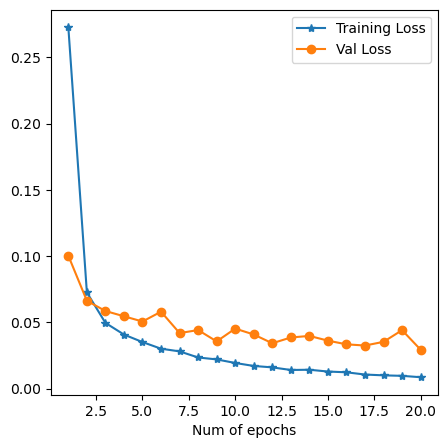

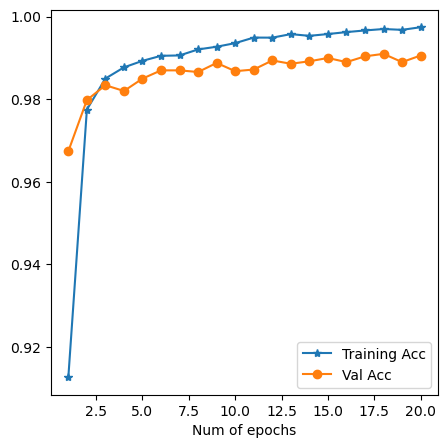

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,21), train_loss, "*-",label="Training Loss")
plt.plot(np.arange(1,21), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()
# plt.savefig('loss_event.png')

fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,21), train_acc, "*-",label="Training Acc")
plt.plot(np.arange(1,21), val_acc,"o-",label="Val Acc")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()
# plt.savefig('accuracy_event.png')

##stAdv Attack

In [6]:
#https://github.com/rakutentech/stAdv - refered code
def flow_st(images,flows):
  images_shape = images.size()
  flows_shape = flows.size()
  batch_size = images_shape[0]
  H = images_shape[2]
  W = images_shape[3]
  basegrid = torch.stack(torch.meshgrid(torch.arange(0,H), torch.arange(0,W))) #(2,H,W)
  sampling_grid = basegrid.unsqueeze(0).type(torch.float32).cuda() + flows.cuda()
  sampling_grid_x = torch.clamp(sampling_grid[:,1],0.0,W-1.0).type(torch.float32)
  sampling_grid_y = torch.clamp(sampling_grid[:,0],0.0,H-1.0).type(torch.float32)

  x0 = torch.floor(sampling_grid_x).type(torch.int64)
  x1 = x0 + 1
  y0 = torch.floor(sampling_grid_y).type(torch.int64)
  y1 = y0 + 1

  x0 = torch.clamp(x0, 0, W - 2)
  x1 = torch.clamp(x1, 0, W - 1)
  y0 = torch.clamp(y0, 0, H - 2)
  y1 = torch.clamp(y1, 0, H - 1)

  Ia = images[:,:,y0[0,:,:], x0[0,:,:]]
  Ib = images[:,:,y1[0,:,:], x0[0,:,:]]
  Ic = images[:,:,y0[0,:,:], x1[0,:,:]]
  Id = images[:,:,y1[0,:,:], x1[0,:,:]]

  x0 = x0.type(torch.float32)
  x1 = x1.type(torch.float32)
  y0 = y0.type(torch.float32)
  y1 = y1.type(torch.float32)

  wa = (x1 - sampling_grid_x) * (y1 - sampling_grid_y)
  wb = (x1 - sampling_grid_x) * (sampling_grid_y - y0)
  wc = (sampling_grid_x - x0) * (y1 - sampling_grid_y)
  wd = (sampling_grid_x - x0) * (sampling_grid_y - y0)

  perturbed_image = wa.unsqueeze(0)*Ia+wb.unsqueeze(0)*Ib+wc.unsqueeze(0)*Ic+wd.unsqueeze(0)*Id

  return perturbed_image.type(torch.float32).cuda()

In [14]:
def default_flow_loss(flows,padding_mode='constant', epsilon=1e-8):
  paddings = (1,1,1,1)
  padded_flows = F.pad(flows,paddings,mode=padding_mode,value=0)
  shifted_flows = [
    padded_flows[:, :, 2:, 2:],  # bottom right (+1,+1)
    padded_flows[:, :, 2:, :-2],  # bottom left (+1,-1)
    padded_flows[:, :, :-2, 2:],  # top right (-1,+1)
    padded_flows[:, :, :-2, :-2]  # top left (-1,-1)
  ]
  #||\Delta u^{(p)} - \Delta u^{(q)}||_2^2 + # ||\Delta v^{(p)} - \Delta v^{(q)}||_2^2
  loss=0
  for shifted_flow in shifted_flows:

    #This should be the loss but works worse and is slower
    up_uq = torch.square(flows[:, 1] - shifted_flow[:, 1])
    vp_vq = torch.square(flows[:, 0] - shifted_flow[:, 0])

    loss += torch.sum(torch.sqrt(up_uq + vp_vq + epsilon)).cuda()

  return loss.type(torch.float32)

def adv_loss(logits,targets,confidence=0.0):
  confidence=torch.tensor(confidence).cuda()
  real = torch.sum(logits*targets,-1)
  other = torch.max((1-targets)*logits-(targets*10000),-1)[0]
  return torch.max(other-real,confidence)[0].type(torch.float32)

In [15]:
def weird_flow_loss(flows,padding_mode='constant', epsilon=1e-8):
  paddings = (1,1,1,1)
  padded_flows = F.pad(flows,paddings,mode=padding_mode,value=0)
  shifted_flows = [
    padded_flows[:, :, 2:, 2:],  # bottom right (+1,+1)
    padded_flows[:, :, 2:, :-2],  # bottom left (+1,-1)
    padded_flows[:, :, :-2, 2:],  # top right (-1,+1)
    padded_flows[:, :, :-2, :-2]  # top left (-1,-1)
  ]
  #||\Delta u^{(p)} - \Delta u^{(q)}||_2^2 + # ||\Delta v^{(p)} - \Delta v^{(q)}||_2^2
  loss=0
  for shifted_flow in shifted_flows:
    #Weird Loss:
    up_uq = torch.square(torch.norm(flows[:, 1] - shifted_flow[:, 1], 2))
    vp_vq = torch.square(torch.norm(flows[:, 0] - shifted_flow[:, 0], 2))

    #This should be the loss but works worse and is slower
    # up_uq = torch.square(flows[:, 1] - shifted_flow[:, 1])
    # vp_vq = torch.square(flows[:, 0] - shifted_flow[:, 0])

    loss += torch.sum(torch.sqrt(up_uq + vp_vq + epsilon)).cuda()

  return loss.type(torch.float32)

In [16]:
losses = [default_flow_loss, weird_flow_loss]

In [17]:
def func(flows,input,target,model,flow_loss,const=0.05):
  input = torch.from_numpy(input).cuda()
  target = torch.from_numpy(target).cuda()
  flows = torch.from_numpy(flows).view((1,2,)+input.size()[2:]).cuda()
  flows.requires_grad=True
  pert_out = flow_st(input,flows)
  output = model(pert_out)
  L_flow = flow_loss(flows)
  L_adv = adv_loss(output,target)
  L_final = L_adv+const*L_flow
  model.zero_grad()
  L_final.backward()
  gradient = flows.grad.data.view(-1).detach().cpu().numpy()
  # print(f'{gradient=}')
  return L_final.item(), gradient

In [18]:
def attack(input,target,model,flow_loss):
  init_flows = np.zeros((1,2,)+input.size()[2:]).reshape(-1)

  results = optimize.fmin_l_bfgs_b(func, init_flows, args=(input.cpu().numpy(), target.cpu().numpy(), model, flow_loss))

  if 'CONVERGENCE' in results[2]['task']:
    flows = torch.from_numpy(results[0]).view((1,2,) + input.size()[2:])
    pert_out = flow_st(input,flows)

  else:
    return None

  return pert_out

Model: NetA
Loss: default_flow_loss


  0%|          | 0/100 [00:00<?, ?it/s]

Success Rate: 0.4500 
Model: NetA
Loss: weird_flow_loss


  0%|          | 0/100 [00:00<?, ?it/s]

Success Rate: 0.5400 
Model: NetB
Loss: default_flow_loss


  0%|          | 0/100 [00:00<?, ?it/s]

Success Rate: 0.4800 
Model: NetB
Loss: weird_flow_loss


  0%|          | 0/100 [00:00<?, ?it/s]

Success Rate: 0.5000 
Model: NetC
Loss: default_flow_loss


  0%|          | 0/100 [00:00<?, ?it/s]

Success Rate: 0.4800 
Model: NetC
Loss: weird_flow_loss


  0%|          | 0/100 [00:00<?, ?it/s]

Success Rate: 0.7200 


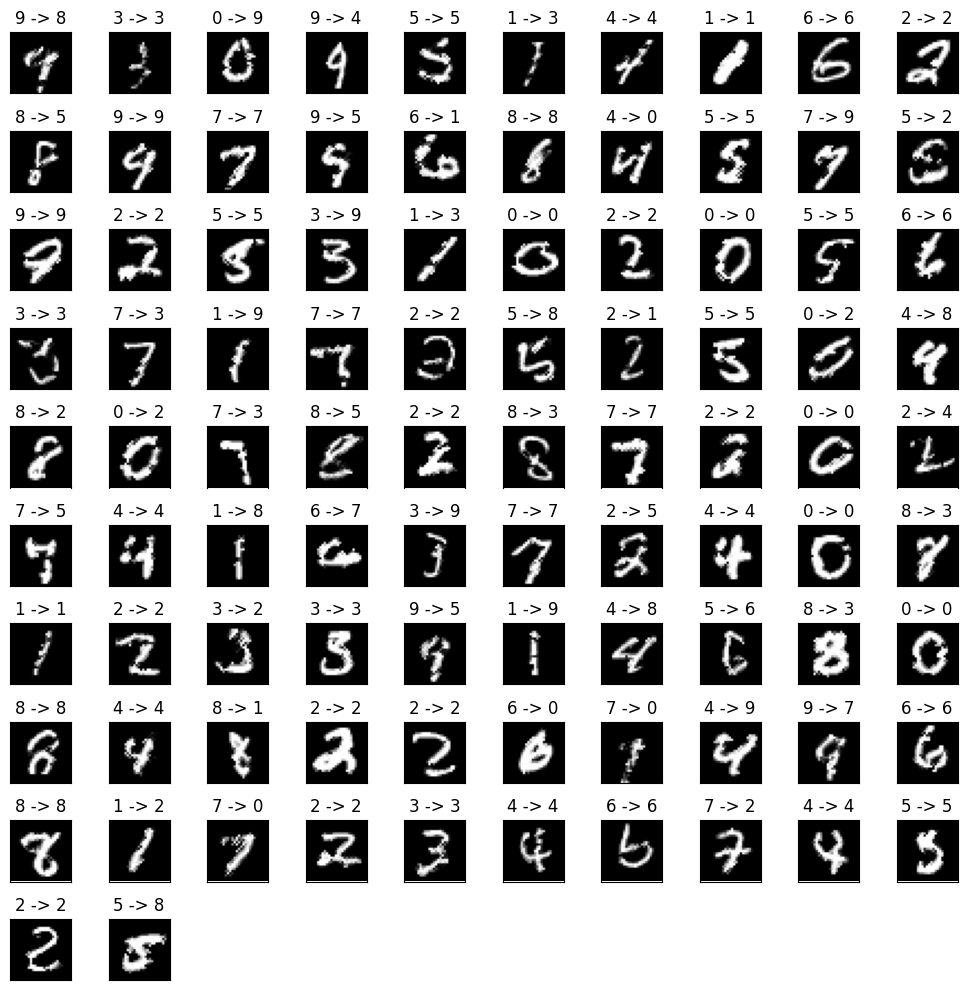

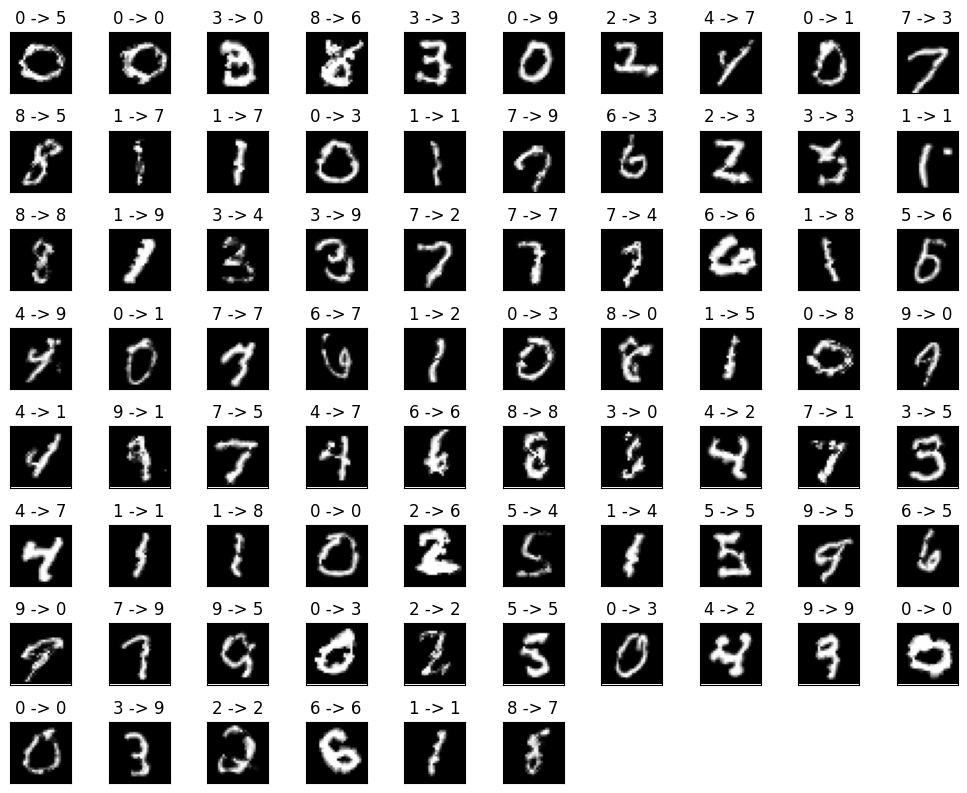

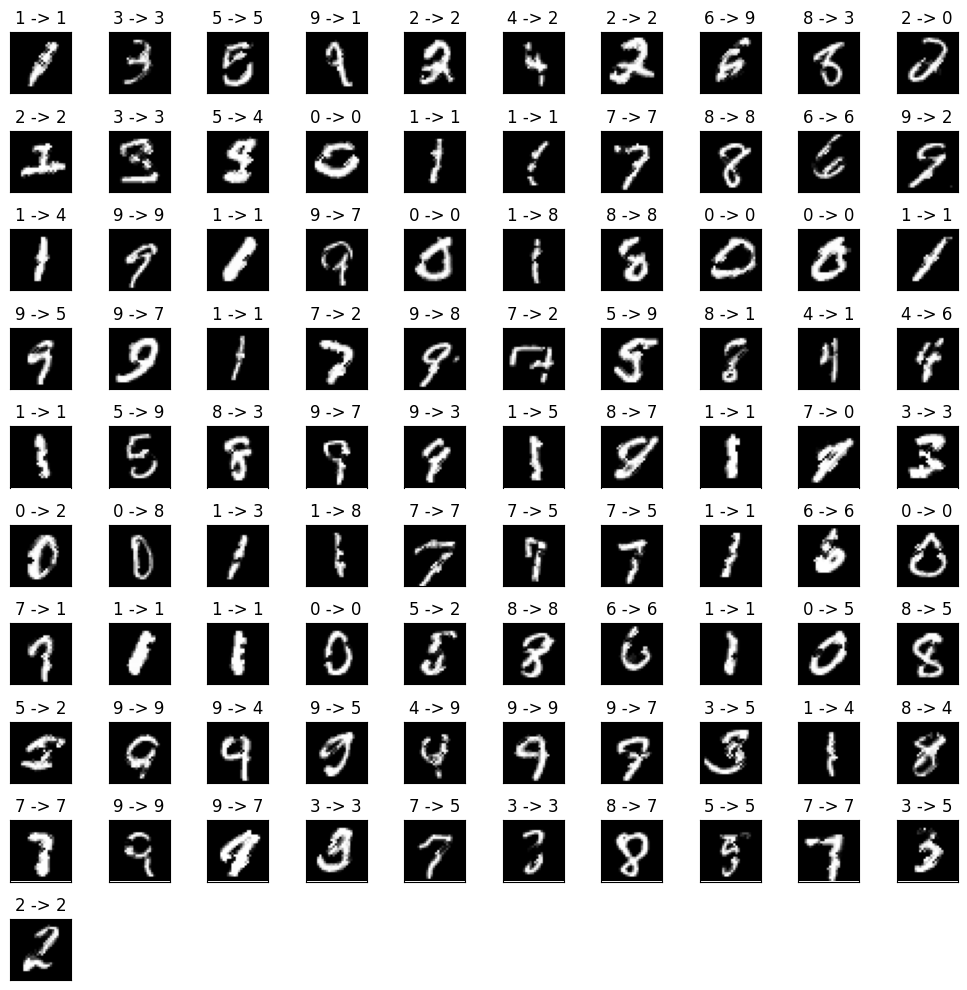

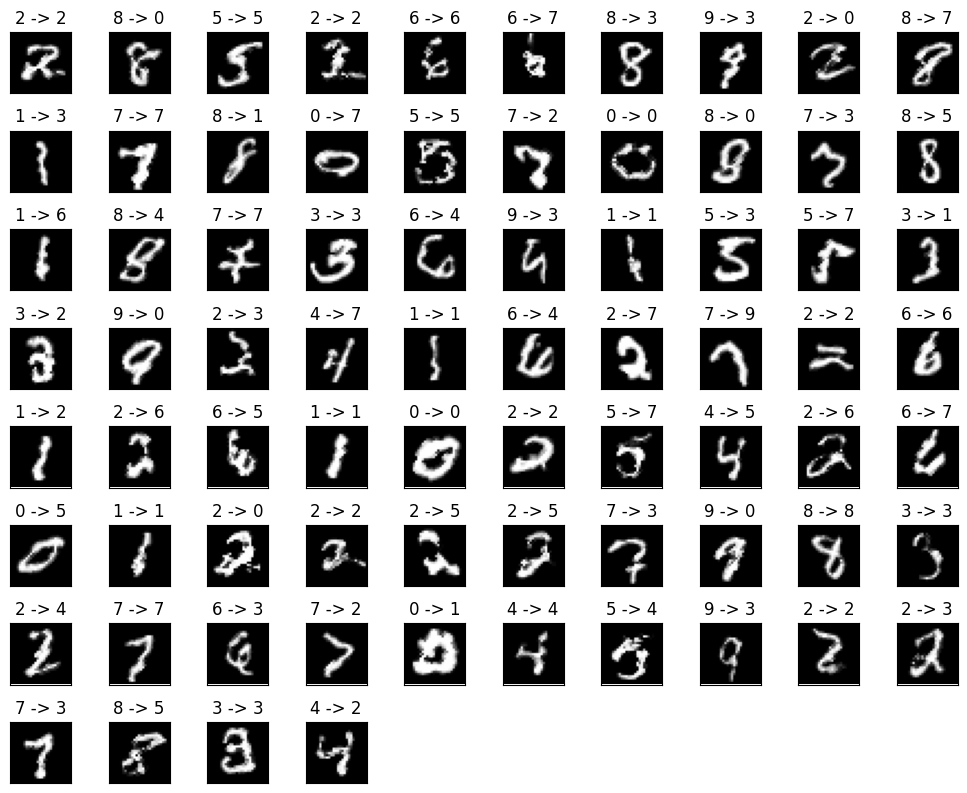

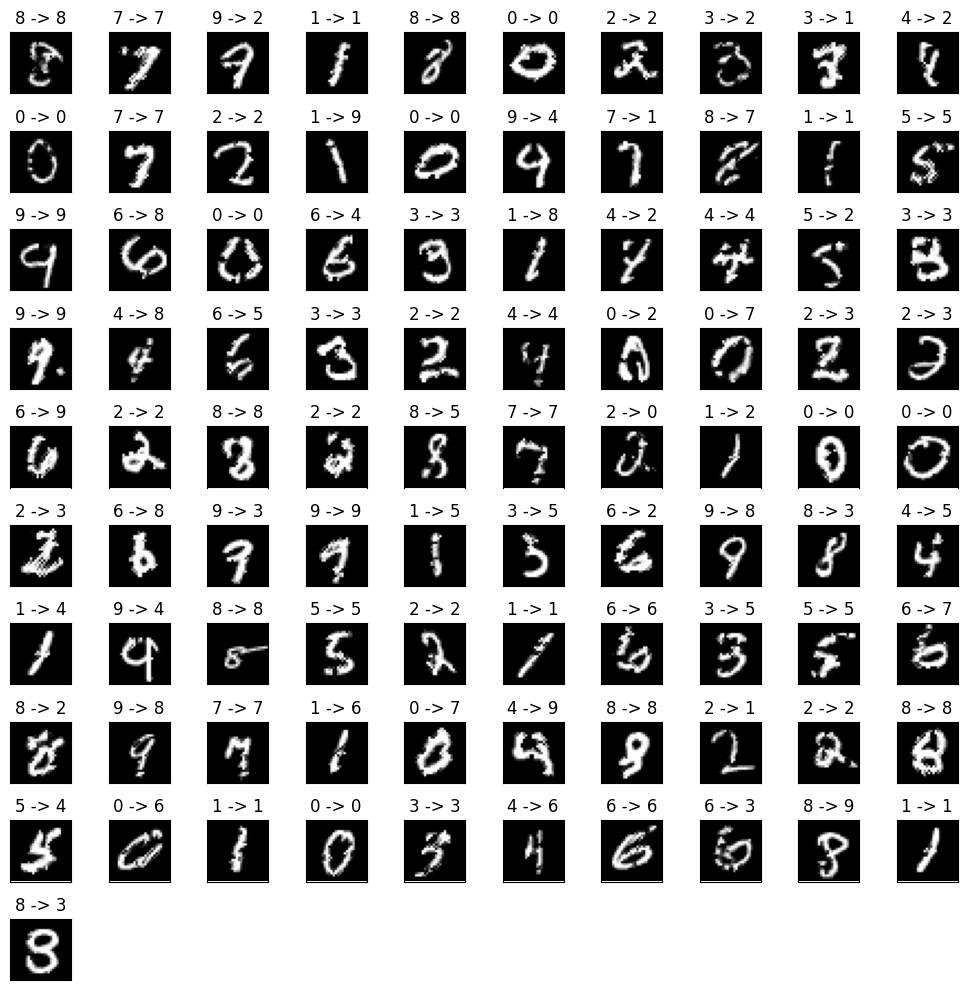

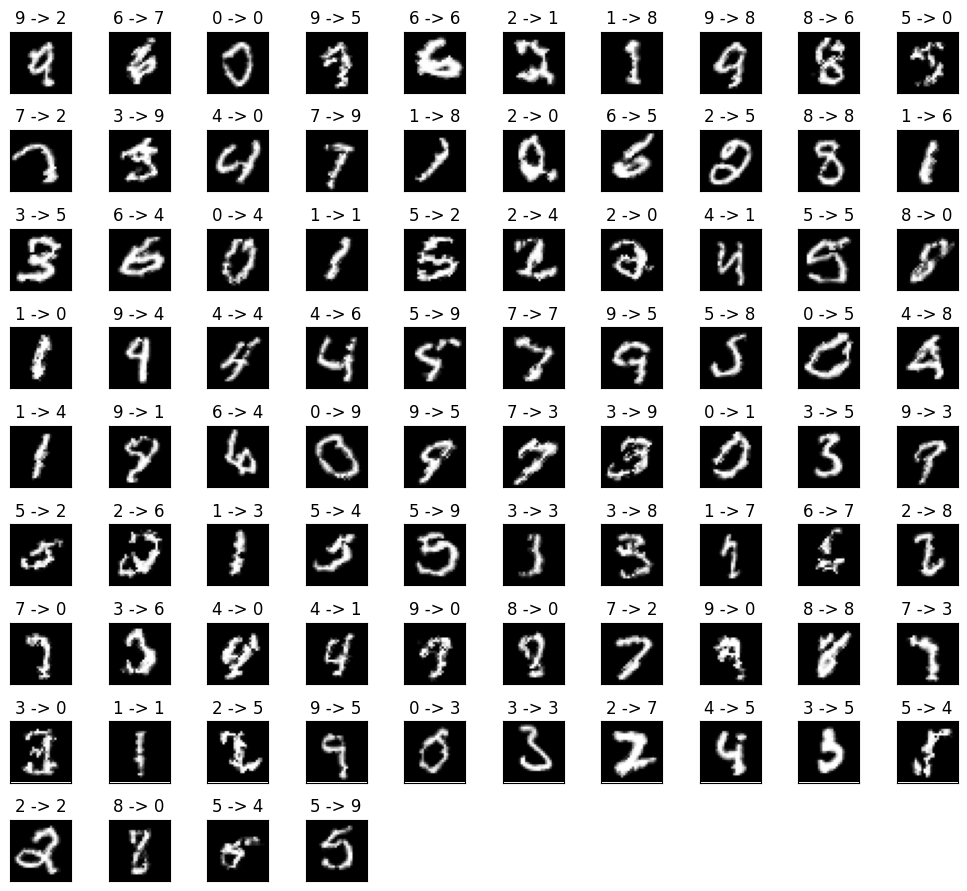

In [21]:
np.random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
testset = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
test_loader = torch.utils.data.DataLoader(testset,batch_size=1,shuffle=True)

use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

for model in models:
  for flow_loss in losses:
    model = model.to(device)
    model.load_state_dict(torch.load(f'./{type(model).__name__}.pt'))
    model.eval()

    adv=[]
    adv_label=[]
    correct_label=[]
    sample=100
    success=0
    print(f"Model: {type(model).__name__}")
    print(f"Loss: {flow_loss.__name__}")
    for i,data in tqdm(enumerate(test_loader), total=sample):
      if i<sample:
        input,label = data[0].to(device),data[1].to(device)
        random_target = np.random.choice([num for num in range(10) if num != label.item()])
        target = torch.from_numpy(np.expand_dims(np.eye(10, dtype=np.float32)[random_target],0)).cuda()
        pert_out = attack(input,target,model, flow_loss)
        if pert_out!=None:
          output =  model(pert_out)
          adv.append(pert_out.squeeze().detach().cpu().numpy())
          correct_label.append(label.item())
          adv_label.append(torch.argmax(output).item())
          if label.item()!=torch.argmax(output).item():
            success+=1
      else:
        break
    print("Success Rate: {:.4f} ".format(success/sample))
    cnt = 0
    plt.figure(figsize=(10,10))

    for i in range(len(adv)):
      cnt += 1
      plt.subplot(10,10,cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      orig,adv_,ex = correct_label[i],adv_label[i],adv[i]
      plt.title("{} -> {}".format(orig, adv_))
      plt.imshow(ex, cmap="gray")

    plt.tight_layout()

    plt.savefig(f"figures/images_{flow_loss.__name__}_{type(model).__name__}.pdf")

Success Rate: 0.7500 


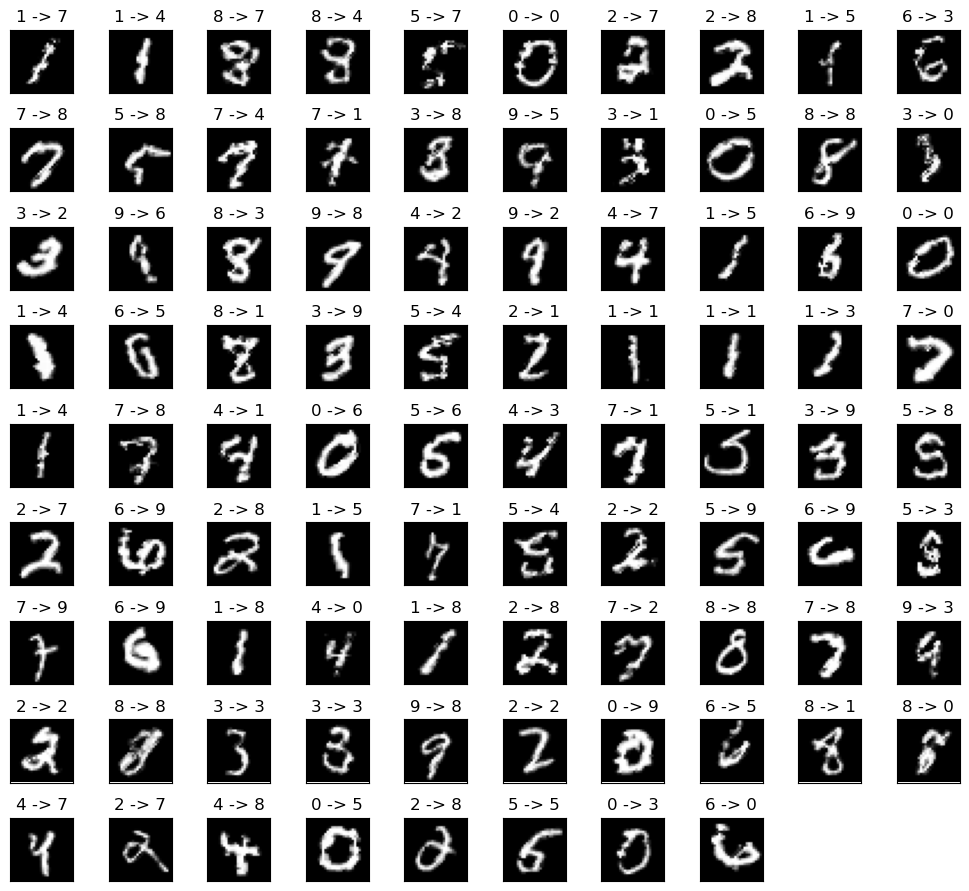